In [8]:
# coding=utf-8
import pandas as pd
import numpy as np
import math
import datetime
import time
from CAL.PyCAL import *
import scipy.stats as st
from scipy.stats.mstats import winsorize
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


file_path = "./junhengguzhi"  # 建立文件夹保存数据量大的数据文件
if not os.path.exists(file_path):
    os.mkdir(file_path)
    
import os
os.environ['NLS_LANG'] = 'SIMPLIFIED CHINESE_CHINA.UTF8'

# Wind数据库
import cx_Oracle
dsn = cx_Oracle.makedsn('172.16.33.207','1521','ORAZXDB')
db = cx_Oracle.connect('windreader','windreader',dsn)

In [34]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:


from multiprocessing.dummy import Pool as ThreadPool
import time
import pandas as pd
import numpy as np
from quartz_extensions import neutralize, standardize, winsorize
import gevent
DataAPI.DataCube.print_mesage = lambda x:0


# In[ ]:


#######################################################################################
#1st Usage:get_data_items(['20070101','20080104'],['LCAP','PE'],set_universe("A")) 
#######################################################################################
#数据IO：取优矿中的因子库因子数据
def get_data_items(date_list, factor_list, universe_list = '', adj = None, thread_count=16, use_datacube=False):
    t_start = time.time()
    if len(universe_list) ==0:
        universe_list = a_universe_list
    pool = ThreadPool(processes = 16)

    def get_factor_by_day(params):
        tdate, data_item_list, my_universe = params
        
        cnt = 0
        while True:
            try:
                if use_datacube:
                    data = get_data_cube(my_universe, data_item_list, tdate, tdate, style='ast', adj=adj)
                    data = data.to_frame(filter_observations=False).reset_index().rename(
                        columns = {"major":"tradeDate","minor":"secID"})
                    data['ticker'] = data['secID'].apply(lambda x:x[:6])
                    data = data[['ticker','tradeDate'] + data_item_list]
                    tmp_frame = data.copy()
                else:
                    tmp_frame = DataAPI.MktStockFactorsOneDayProGet(tradeDate = tdate, secID = my_universe, ticker = u"", field = ['ticker','tradeDate'] + data_item_list,pandas="1")
                    tmp_frame['tradeDate'] = tdate.replace("-","")
                    return tmp_frame
                
            except Exception as e:
                cnt += 1
                print("get data failed in get_factors, reason:%s, retry again, retry count: %s"%(e, cnt)) 
                if cnt >= 3:
                    print("max get data retry, will exit")
                    raise Exception(e)
            return
                
    pool_args = zip(date_list,[factor_list]*len(date_list), [universe_list]*len(date_list))
    frame_list = pool.map(get_factor_by_day, pool_args)
    pool.close()
    pool.join()
    t_end = time.time()
    print("[quant_util.get_data_items] finished!, time cost: %s" %(t_end - t_start))
    return frame_lis


# In[ ]:

def signal_grouping(signal_df, factor_name, ngrp):
    if 'tradeDate' in signal_df.columns:
        date_col = 'tradeDate'
    elif 'date' in signal_df.columns:
        date_col = 'date'
    else:
        raise ValueError("can't support date column in signal_grouping")
    signal_df_tmp = signal_df.copy()
    signal_df_tmp.dropna(subset = [factor_name], inplace =  True)
    signal_df_tmp['group'] = signal_df_tmp.groupby(date_col)[factor_name].apply(lambda x: (x.rank(method = 'first') -1)/len(x) * ngrp).astype(int)
    return signal_df_tmp


#######################################################
# 3rd  Usage:stock_special_tag('20160101','20171231')
######################################################
# 某一时间区间内，根据股票的是否满足某些条件，打上标签
    
    
def stock_special_tag(start_date, end_date, halt =1, st=1,pre_new = 1, pre_new_length = 60):    
    start_date = start_date[:4] + '-' + start_date[4:6] + '-' + start_date[6:]
    end_date = end_date[:4] + '-' + end_date[4:6] + '-' + end_date[6:]
    
    trade_calendar = DataAPI.TradeCalGet(exchangeCD = U"XSHG", field = "calendarDate,isOpen,isMonthEnd" )
    calendar = trade_calendar[trade_calendar['isOpen'] == 1]
    calendar = calendar['calendarDate'].tolist()
        
    #次新股
    new_df = pd.DataFrame(columns = ['ticker','tradeDate','sepcial_flag'])
    if pre_new:
        ipo_info = DataAPI.SecIDGet(assetClass=u"E",field = ['ticker','listDate'],pandas = "1") 
        ipo_info.dropna(inplace = True)
        ticker_list = [ticker for ticker in ipo_info['ticker'] if len(ticker) == 6 and ticker[0] in ['0','3','6']]
        ipo_info = ipo_info[ipo_info['ticker'].isin(ticker_list)]
        ipo_info['permit_idx'] = [
            calendar.index(date) +int(pre_new_length) if date in calendar else int(pre_new_length) for date in ipo_info['listDate']]
        ipo_info['permit_date'] = [calendar[idx] if idx < len(calendar) else calendar[-1] for idx in ipo_info['permit_idx']]
            
        calendar = np.array(calendar)
        new_df_list = []
        for date in calendar[(calendar >= start_date) &(calendar <= end_date)]:
            new_list = ipo_info[(ipo_info['permit_date'] >= date) & (ipo_info['listDate'] <= date)]['ticker'].values
            d_new_df = pd.DataFrame({'tradeDate':[date] *len(new_list), 'ticker':new_list})
            new_df_list.append(d_new_df)
                
        new_df = pd.concat(new_df_list, axis = 0)
        new_df['special_flag'] = 'new'
            
            
    #ST股
    st_df = pd.DataFrame(columns = ['ticker','tradeDate','sepcial_flag'])
    if st:
        st_info = DataAPI.SecSTGet(beginDate = start_date, endDate = end_date, field = ['tradeDate','ticker'], pandas = "1")
        st_df =st_info.copy()
        st_df['speical_flag'] ='st'
            
    #停牌
    halt_df = pd.DataFrame(columns = ['ticker','tradeDate','sepcial_flag'])
    if halt:
        halt_info = DataAPI.SecHaltGet(beginDate = start_date, endDate = end_date, field = ['ticker','haltBeginTime','haltEndTime'], pandas = "1")
        halt_info.fillna(calendar[-1],inplace = True)
        halt_info['haltBeginTime'] = halt_info['haltBeginTime'].apply(lambda x: x[:10])
        halt_info['haltEndTime'] = halt_info['haltEndTime'].apply(lambda x: x[:10])
            
        halt_df_list = []
        for date in calendar[(calendar >= start_date) & (calendar <=  end_date)]:
            halt_list = halt_info[(halt_info['haltEndTime'] >= date) & (halt_info['haltBeginTime'] <= date)]['ticker'].values
            d_halt_df = pd.DataFrame({'tradeDate':[date] * len(halt_list), 'ticker':halt_list})
            halt_df_list.append(d_halt_df)
                
    tag_df = pd.concat([new_df,st_df,halt_df],axis = 0)
    tag_df = tag_df[['ticker','tradeDate','special_flag']]
    tag_df['tradeDate'] = tag_df['tradeDate'].apply(lambda x : x.replace("-",""))
    return tag_df


# In[3]:


def mad_winsorize(dframe,col_list, sigma_n= 3):
    def mad_winsor_by_day(dframe_tdate,col_list,sigma_n):
        dm = dframe_tdate[col_list].median()
        dm1 = (dframe_tdate[col_list] - dm).abs().median()
        
        upper = dm +sigma_n * dm1
        lower = dm - sigma_n *dm1
        for col in col_list:
            tmp_col = dframe_tdate[col]
            tmp_col[tmp_col > upper[col]] = upper[col]
            tmp_col[tmp_col < lower[col]] = lower[col]
            dframe_tdate[col] = tmp_col
        return dframe_tdate
    
    dframe = dframe.groupby(['tradeDate']).apply(mad_winsor_by_day, col_list, sigma_n)
    return dframe


# In[5]:


def neutralize_dframe(dframe,col_list, exclude_style = []):
    def neutralize_by_date(params):
        dframe_by_tdate, col_list, exclue_style = params
        tdate = dframe_by_tdate.tradeDate.values[0]
        
        for col in col_list:
            if len(dframe_by_tdate[col].dropna()) < 11:
                continue
            dframe_by_tdate[col]  = neutralize(dframe_by_tdate[col], target_date = tdate, exclue_style_list = exclude_style)
        return dframe_by_tdate
        
    dframe = dframe.set_index('ticker')
       
    col_lists= []
    frame_list = []
    exclude_lists = []
    for tdate, tdframe in dframe.groupby(['tradeDate']):
        col_lists.append(col_list)
        frame_list.append(tdframe)
        exclude_lists.append(exclude_style)
    jobs =  [gevent.spawn(neutralize_by_date,value) for value in zip(frame_list, col_lists, exclude_lists)]
    gevent.joinall(jobs)
    new_frame_list = [result.value for result in jobs]
    dframe = pd.concat(new_frame_list, axis=0)
    dframe.reset_index(inplace = True)
    return dframe
    


# In[7]:


#########################################
# 
#############################################
def simple_group_backtest(signal_df, return_df, factor_name, return_name, ngrp=5, commission = 0):
    bt_df = signal_df.merge(return_df,on= ['ticker','tradeDate'], how = 'right')
    bt_df.dropna(subset = [factor_name,return_name],inplace = True)
    bt_df= signal_grouping(bt_df,factor_name = factor_name, ngrp=ngrp)
    
    count_df = bt_df.groupby(['tradeDate','group']).apply(lambda x: len(x)).reset_index()
    count_df.columns = ['tradeDate','group','count']
    bt_df = bt_df.merge(count_df, on = ['tradeDate','group'])
    bt_df['weight'] = 1.0/bt_df['count']

    perf = bt_df.groupby(['group','tradeDate']).apply(lambda x: sum(x[return_name] * x['weight'])).reset_index()
    perf.columns = ['group','tradeDate','period_ret']
    if commission >0 :
        adj_df = bt_df.pivot_table(values = 'weight',index ='tradeDate',columns = ['group','ticker']).fillna(0)
        adj_df1 = adj_df.diff().fillna(0)
        comm = (adj_df1[adj_df1<0] * commission).sum(level='group',axis = 1).fillna(0)
        comm = comm.stack().reset_index()
        comm.columns = ['tradeDate','group','cost']
        perf = perf.merge(comm,on  = ['group','tradeDate'])
        perf['period_ret'] = perf['period_ret'] +perf['cost']
    perf.sort_values(['group','tradeDate'], inplace = True)
    perf['cum_ret'] = perf.groupby('group')['period_ret'].apply(lambda x:(x + 1).cumprod())
    
    
    perf['period_ret'] = perf.groupby('group')['period_ret'].shift(1)
    perf['period_ret'].fillna(0,inplace=True)
    perf['cum_ret'] =  perf.groupby('group')['cum_ret'].shift(1)
    perf['cum_ret'].fillna
    return perf[['group','tradeDate','period_ret','cum_ret']], bt_df

# In[6]:


def calc_ic(factor_df, return_df, factor_list,return_col_name = "target_return",ic_type = 'spearman'):
    merge_df = factor_df.merge(return_df,on=['ticker','tradeDate'])
    factor_ic_list = []
    for factor_name in factor_list:
        tmp_factor_ic = merge_df.groupby(['tradeDate']).apply( lambda x: x[[factor_name,return_col_name]].corr(method=ic_type).values[0,1])
        factor_ic_list.append(tmp_factor_ic)
    factor_ic_frame = pd.concat(factor_ic_list, axis=1)
    factor_ic_frame.reset_index(inplace=True)
    return factor_ic_frame



In [10]:
print("该部分进行基础参数设置和数据准备...")

sdate = "2009-01-01"
edate = "2020-12-31"
cal_dates_df = DataAPI.TradeCalGet(exchangeCD=u"XSHG", beginDate=sdate, endDate=edate, field=u"", pandas="1").sort_values('calendarDate')
cal_dates_df['calendarDate'] = cal_dates_df['calendarDate'].apply(lambda x: x.replace('-', ''))
cal_dates_df['prevTradeDate'] = cal_dates_df['prevTradeDate'].apply(lambda x: x.replace('-', ''))
month_end_list = cal_dates_df[cal_dates_df['isMonthEnd']==1]['calendarDate'].values
trade_date_list = cal_dates_df[cal_dates_df['isOpen']==1]['calendarDate'].values

该部分进行基础参数设置和数据准备...


In [11]:
# 全A投资域
a_universe_list = DataAPI.EquGet(equTypeCD=u"A", listStatusCD=u'L', field=u"secID", pandas="1")['secID'].tolist()
a_universe_list_ti = DataAPI.EquGet(equTypeCD=u"A", listStatusCD=u'L', field=u"ticker", pandas="1")['ticker'].tolist()
stock_list = [sec[:6] for sec in a_universe_list]
ticker_list =  [sec[:6] for sec in a_universe_list_ti]

In [12]:
# 获取个股月度收益率
mret_df = DataAPI.MktEqumAdjGet(beginDate=sdate, endDate=edate, secID=a_universe_list, field=u"ticker,endDate,chgPct", pandas="1")
mret_df.rename(columns={'endDate':'tradeDate', 'chgPct':'curr_ret'}, inplace=True)  # 交易日列和收益率列
mret_df['tradeDate'] = mret_df['tradeDate'].apply(lambda x: x.replace('-', ''))
mret_df.sort_values(['ticker', 'tradeDate'], inplace=True)
mret_df['nxt_ret'] = mret_df.groupby('ticker')['curr_ret'].shift(-1)
print ("个股收益率:", mret_df.head().to_html())

个股收益率: <table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>ticker</th>
      <th>tradeDate</th>
      <th>curr_ret</th>
      <th>nxt_ret</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>000001</td>
      <td>20090123</td>
      <td>0.230228</td>
      <td>0.185508</td>
    </tr>
    <tr>
      <th>1</th>
      <td>000001</td>
      <td>20090227</td>
      <td>0.185508</td>
      <td>0.155101</td>
    </tr>
    <tr>
      <th>2</th>
      <td>000001</td>
      <td>20090331</td>
      <td>0.155101</td>
      <td>0.023871</td>
    </tr>
    <tr>
      <th>3</th>
      <td>000001</td>
      <td>20090430</td>
      <td>0.023871</td>
      <td>0.093258</td>
    </tr>
    <tr>
      <th>4</th>
      <td>000001</td>
      <td>20090527</td>
      <td>0.093258</td>
      <td>0.223032</td>
    </tr>
  </tbody>
</table>


In [13]:
# 股票池筛选(剔除上市不满60个交易日的次新股、st股、停牌个股、一字板个股)及保存pkl文件  
if not os.path.exists(os.path.join(file_path, 'forbidden_pool.pkl')):
    forbidden_pool = stock_special_tag(sdate, edate, pre_new_length=60)  # 次新股、st股、停牌个股
    # 筛选一字板个股
    mkt_df = DataAPI.MktEqudGet(beginDate=sdate, endDate=edate, secID=a_universe_list, field=u"ticker,tradeDate,highestPrice,lowestPrice", pandas="1")
    mkt_df['tradeDate'] = mkt_df['tradeDate'].apply(lambda x: x.replace('-', ''))
    limit_df = mkt_df[(mkt_df['highestPrice'] == mkt_df['lowestPrice']) & (mkt_df['highestPrice']>0)][['ticker', 'tradeDate']]
    limit_df['special_flag'] = 'limit'
    forbidden_pool = forbidden_pool.append(limit_df)
    forbidden_pool = forbidden_pool.merge(cal_dates_df, left_on=['tradeDate'], right_on=['calendarDate'])
    forbidden_pool = forbidden_pool[['ticker', 'tradeDate', 'prevTradeDate', 'special_flag']]
    forbidden_pool.to_pickle(os.path.join(file_path, 'forbidden_pool.pkl'))
else:
    forbidden_pool = pd.read_pickle(os.path.join(file_path, 'forbidden_pool.pkl'))       
print ("禁止股票池:", forbidden_pool.head().to_html())

# 在月行情数据中剔除个股
mret_df = mret_df.merge(forbidden_pool[['ticker', 'prevTradeDate', 'special_flag']], left_on=['ticker',
'tradeDate'], right_on=['ticker', 'prevTradeDate'], how='left')
mret_df = mret_df[mret_df['special_flag'].isnull()]
mret_df = mret_df.drop(['prevTradeDate', 'special_flag'], axis=1)

# 沪深300、中证500、中证800指数成分股
idx_dict={300:"000300", 500:"000905", 800:"000906"}
idx_stock_list=[]
idx_stock_dict={}
for idx in idx_dict:
    df_tmp = DataAPI.mIdxCloseWeightGet(secID=u"", ticker=idx_dict[idx], beginDate=sdate, endDate=edate, field=u"consTickerSymbol,effDate", pandas="1")
    df_tmp.rename(columns={'consTickerSymbol':'ticker', 'effDate':'tradeDate'}, inplace=True)
    df_tmp['tradeDate'] = df_tmp['tradeDate'].apply(lambda x: x.replace('-', ''))
    idx_stock_dict[idx] = df_tmp.copy()
df_hs300 = idx_stock_dict[300].copy()
df_zz500 = idx_stock_dict[500].copy()
df_zz800 = idx_stock_dict[800].copy()
print ("沪深300指数成分股:", df_hs300.head().to_html())
# 获取指数月度收益
idx_list = [u"000300", u"000905", u"000906", u"DY0001"]
month_idx_ret_df = DataAPI.MktIdxmGet(beginDate=sdate, endDate=edate, indexID=u"", ticker=idx_list, field=u"indexID,endDate,chgPct", pandas="1")
month_idx_ret_df['indexID'] = month_idx_ret_df['indexID'].apply(lambda x: x.replace('.ZICN', ''))
month_idx_ret_df.rename(columns={'endDate':'tradeDate'}, inplace=True)
month_idx_ret_df['tradeDate'] = month_idx_ret_df['tradeDate'].apply(lambda x: x.replace('-', ''))
month_idx_ret_df = pd.pivot_table(month_idx_ret_df, index='tradeDate', columns='indexID', values='chgPct')
print( "指数月度收益率:", month_idx_ret_df.head().to_html())

print ("获取个股所在申万一级行业数据...")
if not os.path.exists(os.path.join(file_path, 'indus_df.pkl')):
    indu_df_list = []
    for tdate in month_end_list:
        indus_tmp = DataAPI.EquIndustryGet(secID=a_universe_list, intoDate=tdate, industryVersionCD=u"010317", field=['ticker', 'industryName1'], pandas="1")
        indus_tmp['tradeDate'] = tdate    
        indu_df_list.append(indus_tmp)
    indus_df = pd.concat(indu_df_list)
    indus_df['tradeDate'] = indus_df['tradeDate'].apply(lambda x: x.replace('-', ''))
    indus_df.to_pickle(os.path.join(file_path, 'indus_df.pkl'))
else:
    indus_df = pd.read_pickle(os.path.join(file_path, 'indus_df.pkl')) 
print ("个股行业数据: ", indus_df.head().to_html())


禁止股票池: <table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>ticker</th>
      <th>tradeDate</th>
      <th>prevTradeDate</th>
      <th>special_flag</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>601727</td>
      <td>20090105</td>
      <td>20081231</td>
      <td>new</td>
    </tr>
    <tr>
      <th>1</th>
      <td>000004</td>
      <td>20090105</td>
      <td>20081231</td>
      <td>NaN</td>
    </tr>
    <tr>
      <th>2</th>
      <td>000007</td>
      <td>20090105</td>
      <td>20081231</td>
      <td>NaN</td>
    </tr>
    <tr>
      <th>3</th>
      <td>000008</td>
      <td>20090105</td>
      <td>20081231</td>
      <td>NaN</td>
    </tr>
    <tr>
      <th>4</th>
      <td>000010</td>
      <td>20090105</td>
      <td>20081231</td>
      <td>NaN</td>
    </tr>
  </tbody>
</table>
沪深300指数成分股: <table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
   

In [14]:
print( "风格因子计算..."    )
style_list = ['BETA', 'SIZE', 'RESVOL', 'MOMENTUM', 'SIZENL', 'EARNYILD', 'BTOP', 'GROWTH', 'LEVERAGE', 'LIQUIDTY']
if not os.path.exists(os.path.join(file_path, 'style_fac.pkl')):
    #  由于优矿返回数据量的限制，逐年获取数据
    style_df_list = []
    for i in range(12):
        year = 2009+i
        startdate = str(year) + "0101"
        enddate = str(year) + "1231" if year<2020 else edate.replace('-', '')
        style_df = DataAPI.RMExposureDayGet(secID=a_universe_list, beginDate=startdate, endDate=enddate, field=['ticker','tradeDate'] + style_list, pandas="1")
        style_df_list.append(style_df)
    style_fac_df = pd.concat(style_df_list)
    style_fac_df.to_pickle(os.path.join(file_path, 'style_fac.pkl'))
else:
    style_fac_df = pd.read_pickle(os.path.join(file_path, 'style_fac.pkl'))
    style_fac_df.sort_values(['ticker', 'tradeDate'], inplace=True)
print( "风格因子数据:", style_fac_df.head().to_html())

if not os.path.exists(os.path.join(file_path, 'pe_df.pkl')):
    pe_df = pd.concat(get_data_items(month_end_list, ['PE', 'NPParentCompanyGrowRate', 'NegMktValue'], a_universe_list))
    pe_df = pe_df.sort_values(['ticker', 'tradeDate'])
    pe_df.to_pickle(os.path.join(file_path, 'pe_df.pkl'))
else:
    pe_df = pd.read_pickle(os.path.join(file_path, 'pe_df.pkl'))
    
print ("市盈率、历史归母净利润增速和流通市值数据:", pe_df.head().to_html())

风格因子计算...
风格因子数据: <table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>ticker</th>
      <th>tradeDate</th>
      <th>BETA</th>
      <th>SIZE</th>
      <th>RESVOL</th>
      <th>MOMENTUM</th>
      <th>SIZENL</th>
      <th>EARNYILD</th>
      <th>BTOP</th>
      <th>GROWTH</th>
      <th>LEVERAGE</th>
      <th>LIQUIDTY</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>23571</th>
      <td>000001</td>
      <td>20090105</td>
      <td>0.756</td>
      <td>0.844</td>
      <td>-0.317</td>
      <td>-0.717</td>
      <td>0.169</td>
      <td>3.061</td>
      <td>0.535</td>
      <td>-0.160</td>
      <td>0.098</td>
      <td>0.264</td>
    </tr>
    <tr>
      <th>23474</th>
      <td>000001</td>
      <td>20090106</td>
      <td>0.794</td>
      <td>0.871</td>
      <td>-0.321</td>
      <td>-0.628</td>
      <td>0.149</td>
      <td>2.996</td>
      <td>0.479</td>
      <td>-0.156</td>
      <td>0.100</td>
      <td>0.275<

In [15]:
if not os.path.exists(os.path.join(file_path, 'conses_df.pkl')):
    sql = """select 
S_INFO_WINDCODE,
EST_DT,
S_EST_YEARTYPE,
EST_REPORT_DT,
NET_PROFIT_AVG
from wind.ashareconsensusdata"""
    a2 = pd.read_sql(sql,db)
    a2['S_INFO_WINDCODE'] = a2['S_INFO_WINDCODE'].map(lambda x: str(x)[:6])
    a3 = a2.rename(columns = {'S_INFO_WINDCODE':'secCode', 'EST_DT': 'repForeTime', "S_EST_YEARTYPE":"ConProfitType",'EST_REPORT_DT':'foreYear','NET_PROFIT_AVG':'conProfit'})
    con_profit_df = a3
    con_profit_df.to_pickle(os.path.join(file_path, 'conses_df.pkl'))
else:
    con_profit_df = pd.read_pickle(os.path.join(file_path, 'conses_df.pkl')) 


In [16]:
con_profit_df['foreYear'] =con_profit_df['foreYear'].map(lambda x: str(x)[:4])
con_profit_df = con_profit_df.sort_values(['secCode', 'repForeTime', 'foreYear'])
con_profit_df = con_profit_df.reset_index()
con_profit_df = con_profit_df.drop(['index'], axis = 1)
con_profit_df['foreYear']= con_profit_df['foreYear'].astype(int)
con_profit_df['conProfit']= con_profit_df['conProfit'].astype(float)
con_profit_df['ConProfitType'] = np.where((con_profit_df.ConProfitType == 'FY1'), 0, con_profit_df.ConProfitType)
con_profit_df['ConProfitType'] = np.where((con_profit_df.ConProfitType == 'FY2'), 1, con_profit_df.ConProfitType)
con_profit_df['ConProfitType'] = np.where((con_profit_df.ConProfitType == 'FY3'), 2, con_profit_df.ConProfitType)
#数据里没有base year data...

In [17]:
# 历史净利润增速计算BET和PEG因子
pe_df['PEG_h'] = np.where(pe_df.NPParentCompanyGrowRate==0, np.nan, pe_df['PE']/pe_df['NPParentCompanyGrowRate'])
pe_df['PEG_h'] = np.where((pe_df.PE<0)|(pe_df.NPParentCompanyGrowRate<0), np.nan, pe_df['PEG_h']) 
pe_df['BET_h'] = np.log((1+pe_df['NPParentCompanyGrowRate']*(pe_df['PE'])).tolist()) / np.log((1+pe_df['NPParentCompanyGrowRate']).tolist())
pe_df['BET_h'] = np.where((pe_df['PE']<0)|(pe_df['NPParentCompanyGrowRate']<=0), np.nan, pe_df['BET_h']) 

print ("历史净利润增速计算的PEG和BET因子数据:", pe_df.head().to_html())
pe_df

历史净利润增速计算的PEG和BET因子数据: <table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>ticker</th>
      <th>tradeDate</th>
      <th>PE</th>
      <th>NPParentCompanyGrowRate</th>
      <th>NegMktValue</th>
      <th>PEG_h</th>
      <th>BET_h</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>000001</td>
      <td>20090123</td>
      <td>8.8309</td>
      <td>0.7695</td>
      <td>3.241281e+10</td>
      <td>11.476153</td>
      <td>3.598286</td>
    </tr>
    <tr>
      <th>0</th>
      <td>000001</td>
      <td>20090227</td>
      <td>10.4696</td>
      <td>0.7695</td>
      <td>3.842756e+10</td>
      <td>13.605718</td>
      <td>3.861010</td>
    </tr>
    <tr>
      <th>0</th>
      <td>000001</td>
      <td>20090331</td>
      <td>80.6153</td>
      <td>-0.7683</td>
      <td>4.438662e+10</td>
      <td>NaN</td>
      <td>NaN</td>
    </tr>
    <tr>
      <th>0</th>
      <td>000001</td>
      <td>20090430</td>
 

,ticker,tradeDate,PE,NPParentCompanyGrowRate,NegMktValue,PEG_h,BET_h
0,000001,20090123,8.8309,0.7695,3.241281e+10,11.476153,3.598286
0,000001,20090227,10.4696,0.7695,3.842756e+10,13.605718,3.861010
0,000001,20090331,80.6153,-0.7683,4.438662e+10,NaN,NaN
0,000001,20090430,69.2425,-0.7653,4.544477e+10,NaN,NaN
0,000001,20090527,75.6916,-0.7653,4.967737e+10,NaN,NaN
0,000001,20090630,92.5779,-0.7653,6.379637e+10,NaN,NaN
0,000001,20090731,111.0765,-0.7653,7.654395e+10,NaN,NaN
0,000001,20090831,72.2731,-0.7870,5.318314e+10,NaN,NaN
0,000001,20090930,79.5044,-0.7870,5.850437e+10,NaN,NaN
0,000001,20091030,74.7064,-0.7717,6.573409e+10,NaN,NaN


In [18]:
# 展示4个代表性行业（截止2020年12月31日）PE与BET因子值对比
fac_ind_df = pe_df.merge(indus_df, on=['ticker', 'tradeDate'])
# 由于一级行业综合金融产生时间晚、数据量少，将其删除
fac_ind_df = fac_ind_df[fac_ind_df.industryName1 != '综合金融']
# 去极值
w_fac_ind_df = mad_winsorize(fac_ind_df, ['BET_h', 'PE'], sigma_n=5)

Text(0.5, 1.0, '四个申万一级行业PE因子(截止2020.12.31)')

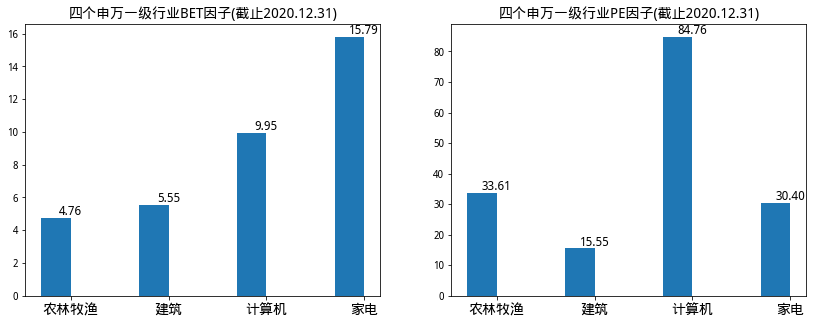

In [19]:
# 分行业，流通市值加权BET_h因子 
ind_bet_df = w_fac_ind_df.dropna(subset=['BET_h']).groupby(['tradeDate', 'industryName1']).apply(lambda df: sum(df['BET_h'].mul(df['NegMktValue']))/sum(df['NegMktValue'])).reset_index().rename(columns={0:'BET_h_w'})
BET_dist = pd.pivot_table(ind_bet_df, index='tradeDate', columns='industryName1', values='BET_h_w')
# 分行业，流通市值加权PE
ind_pe_df = w_fac_ind_df[w_fac_ind_df.PE>=0].groupby(['tradeDate', 'industryName1']).apply(lambda df: sum(df['PE'].mul(df['NegMktValue']))/sum(df['NegMktValue'])).reset_index().rename(columns={0:'PE_w'})
PE_dist = pd.pivot_table(ind_pe_df, index='tradeDate', columns='industryName1', values='PE_w')

indu_col = ['农林牧渔', '建筑', '计算机', '家电']
dist_df1 = BET_dist.loc['20201231'][indu_col]
dist_df2 = PE_dist.loc['20201231'][indu_col]
fig = plt.figure(figsize=(14, 5))
ax1 = fig.add_subplot(121)
plot_baseline = np.arange(4)+1
ax1.bar(plot_baseline, dist_df1, width=0.3)
ax1.set_xticks(plot_baseline + 0.15)
ax1.set_xticklabels([x for x in indu_col], fontproperties=font, fontsize=14)
ax2 = fig.add_subplot(122)
ax2.bar(plot_baseline, dist_df2, width=0.3)
ax2.set_xticks(plot_baseline + 0.15)
ax2.set_xticklabels([x for x in indu_col], fontproperties=font, fontsize=14)
for x,y1,y2 in zip(plot_baseline, np.array(dist_df1.astype(float)), np.array(dist_df2.astype(float))):  # 展示数字标签
    ax1.text(x+0.15, y1, '%.2f' % y1, fontdict={'fontsize':12}, verticalalignment='bottom', horizontalalignment='center')
    ax2.text(x+0.15, y2, '%.2f' % y2, fontdict={'fontsize':12}, verticalalignment='bottom', horizontalalignment='center')
    
ax1.set_title(u"四个申万一级行业BET因子(截止2020.12.31)", fontproperties=font, fontsize=14)
ax2.set_title(u"四个申万一级行业PE因子(截止2020.12.31)", fontproperties=font, fontsize=14)

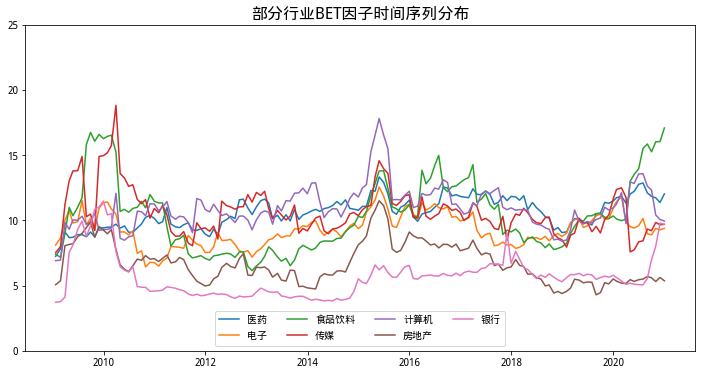

In [20]:
# 部分行业BET因子时间序列分布
ind_list = [u'医药', u'电子', u'食品饮料', u'传媒', u'计算机', u'房地产', u'银行']
tar_BET_df = BET_dist[[ind for ind in ind_list]]
tar_BET_df.index = pd.to_datetime(tar_BET_df.index)
fig = plt.figure(figsize=(12,6))
plt.plot(tar_BET_df.index, tar_BET_df)
plt.legend(ind_list, loc='lower center', ncol=4, prop=font)
plt.ylim(0, 25)
plt.title(u"部分行业BET因子时间序列分布", fontproperties=font, fontsize=16)
plt.show()

Text(0.5, 1.0, '行业估值离散度时间序列分布')

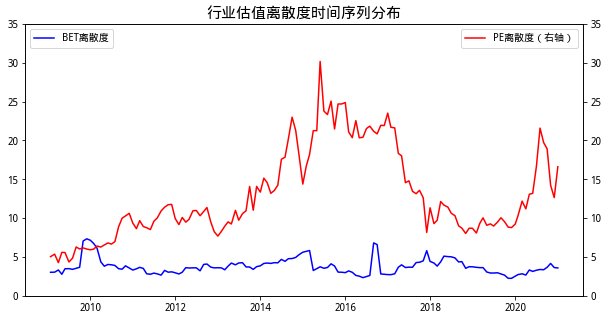

In [21]:

# 去极值缩尾处理后计算行业估值离散度(考虑到数据分布差异，BET因子和PE因子进行1%缩尾)
#w_BET_dist = pd.DataFrame(winsorize(BET_dist,win_type='QuantileDraw', pvalue =0.01), columns=BET_dist.columns, index=BET_dist.index)
BET_vari = BET_dist.max(axis=1) / BET_dist.min(axis=1)  #离散度


#w_PE_dist = pd.DataFrame(winsorize(PE_dist, win_type='QuantileDraw', pvalue =0.01), columns=PE_dist.columns, index=PE_dist.index)
PE_vari = PE_dist.max(axis=1) / PE_dist.min(axis=1)

# 离散度画图
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.plot(pd.to_datetime(BET_vari.index), BET_vari, label=u'BET离散度', color='b')
ax.grid(False)
ax.set_ylim((0, 35))
ax1 = ax.twinx()
ax1.plot(pd.to_datetime(PE_vari.index), PE_vari, label=u'PE离散度（右轴）', color='r')
ax1.grid(False)
ax1.set_ylim((0, 35))
ax.legend(prop=font, loc=2)
ax1.legend(prop=font, loc=1)
ax.set_title(u'行业估值离散度时间序列分布', fontproperties=font, fontsize=15)

In [22]:
# 基础函数准备
def fac_process(factor_df, factor_list):
    '''
    因子处理函数
    '''
    # 去极值
    w_factor_df = mad_winsorize(factor_df, factor_list, sigma_n=3)
    # 完全中性化
    n_factor_df = neutralize_dframe(w_factor_df.copy(), factor_list, exclude_style=[])

    # 标准化
    s_factor_df = n_factor_df.copy()
    s_factor_df[factor_list] = s_factor_df.groupby('tradeDate')[factor_list].apply(lambda df: (df-df.mean()) / df.std())
    return s_factor_df
    
def back_test(factor_df, factor_list, ngrp):
    '''
    分组回测测试
    ngrp: 组数
    '''
    perf_list = []
    for fn in factor_list:
        perf, _ = simple_group_backtest(factor_df, mret_df, factor_name=fn, return_name='nxt_ret', commission=0.003, ngrp=ngrp)
        perf_list.append(perf.pivot_table(values='period_ret', index='tradeDate', columns='group'))
    perf_df = pd.concat(perf_list, axis=1)
    perf_df.columns = pd.MultiIndex.from_tuples([(fn, col) for fn in factor_list for col in range(int(ngrp))])
    return perf_df

def factor_test_summary(factor_df, factor_list, ngrp):
    """·
    综合因子测试方法：IC测试分析法、分组测试分析法
    参数：
        factor_df: DataFrame, 因子值
        factor_df: list, 因子列表
    返回：
        IC序列、分组收益率序列
    """
    # IC测试
    ic_df = calc_ic(factor_df, mret_df, factor_list, return_col_name='nxt_ret', ic_type='spearman')
    # 分组回测
    perf_df = back_test(factor_df, factor_list, ngrp)
    return ic_df, perf_df

def proc_float_scale(df, col_name, format_str):
    """
    格式化输出
    参数：
        df: DataFrame, 需要格式化的数据
        col_name： list, 需要格式化的列名
        format_str：格式类型
    """
    for col in col_name:
        for index in df.index:
            df.ix[index, col] = format(df.ix[index, col], format_str)
    return df    

def ic_describe(ic_df, factor_list, annual_len):
    """
    统计IC的均值、标准差、T值、IC_IR、大于0的比例
    参数:
        ic_df: DataFrame, IC值，index为日期，columns为因子名，values为各个因子的IC值   
        factor_list: list, 因子列表
        annual_len: int, 年化周期数。若是月频结果，则通常为12；若是周频结果，则通常为52
    返回: DataFrame, IC统计结果
    """
    ic_df = ic_df.dropna()    
    # 记录因子个数和因子名
    n = len(factor_list)
    # IC均值
    ic_mean = ic_df[factor_list].mean()
    # IC标准差
    ic_std = ic_df[factor_list].std()
    # IC均值的T统计量
    ic_t = pd.Series(st.ttest_1samp(ic_df[factor_list], 0)[0], index=factor_list)
    # IC_IR                                     
    ic_ir = ic_mean/ic_std*np.sqrt(annual_len)
    # IC大于0的比例
    ic_p_pct = (ic_df[factor_list] > 0).sum()/len(ic_df)    
    # IC统计
    ic_table = pd.DataFrame([ic_mean, ic_std, ic_t, ic_ir, ic_p_pct], index=['IC', 'IC标准差', 'IC均值T统计量','ICIR', 'IC大于0的比例']).T
    ic_table = proc_float_scale(ic_table, ['IC', 'IC标准差', 'IC大于0的比例'], ".2%")
    ic_table = proc_float_scale(ic_table, ['IC均值T统计量', 'ICIR'], ".2f")
    return ic_table

def group_perf_describe(perf_df, factor_list, ngrp, idx_col, annual_len=12):
    """
    统计因子的回测绩效，包括年化收益率、年化波动率、夏普比率、最大回撤
    参数:
        perf_df: DataFrame, 回测的期间收益率，index为日期，columns为因子名，values为因子回测的期间收益率
        factor_df: list, 因子列表
        idx_col: 指数名称：'000300'代表沪深300，'000905'代表中证500，'DY0001'代表通联全A
        annual_len: int, 年化周期数。若是月频结果，则通常为12；若是周频结果，则通常为52
    返回: DataFrame, 返回回测绩效
    """
    # 计算分组年化平均超额收益
    perf_df = perf_df.dropna()
    ec_perf_df = perf_df.copy()
    for fac in factor_list: 
        ec_perf_df[fac] = perf_df[fac].values - month_idx_ret_df.loc[perf_df.index][[idx_col]*ngrp].values
    ec_perf_df.ix[0, :] = 0
    n = len(factor_list)
    group_res = (perf_df.mean()*annual_len).reset_index()
    group_res.columns = ['factor_name', 'group', 'value']
    group_res = group_res.pivot_table(values='value', index='factor_name', columns='group')
    
    # 计算多空收益序列
    sub_res = pd.concat([perf_df[(fn, int(ngrp)-1)] - perf_df[(fn, 0)] for fn in factor_list], axis=1)
    sub_res.columns = factor_list

    # 年化收益率
    ret_mean = sub_res.mean()*annual_len
    # 年化波动率
    ret_std = sub_res.std()*np.sqrt(annual_len)
    # 年化IR
    ir = ret_mean / ret_std
    # 最大回撤
    maxdrawdown = {}
    for i in range(n):
        fname = factor_list[i]
        cum_ret = pd.DataFrame((sub_res[fname]+1).cumprod())
        cum_max = cum_ret.cummax()
        maxdrawdown[fname] = ((cum_max-cum_ret)/cum_max).max().values[0]
    maxdrawdown = pd.Series(maxdrawdown)
    # 月度胜率
    win_ret = (sub_res > 0).sum()/(len(sub_res)-1)

    ls_res = pd.DataFrame([ret_mean, ret_std, ir, maxdrawdown, win_ret], index=['ls_ret', 'ls_std', 'ls_ir', 'ls_md', 'ls_win']).T

    group_table = pd.concat([ls_res, group_res], axis=1)
    group_table.columns = ['多空组合年化收益', '多空年化波动', '多空夏普比', '多空最大回撤', '多空月度胜率'] + ['第%s组超额收益'%i for i in range(1, int(ngrp)+1)]
    group_table = proc_float_scale(group_table, ['多空组合年化收益', '多空年化波动', '多空最大回撤', '多空月度胜率']+['第%s组超额收益'%i for i in range(1, int(ngrp)+1)], ".2%")
    group_table = proc_float_scale(group_table, ['多空夏普比'], ".2f")
    return ec_perf_df, group_table.loc[factor_list, :]

def test_discribe(ic_df, perf_df, factor_list, idx_col, ngrp):
    """
    综合因子分析结果统计
    参数:
        ic_res: DataFrame, IC值， index为日期， columns为因子名， values为各个因子的IC值
        perf_df: DataFrame, 回测的期间收益率， index为日期， columns为因子名， values为因子回测的期间收益率
        factor_df: list, 因子列表
    """
    ic_table = ic_describe(ic_df, factor_list, annual_len=12)
    ec_perf_df, group_table = group_perf_describe(perf_df, factor_list, ngrp, idx_col)
    print( 'IC结果分析', ic_table.to_html())
    print ('分组回测结果分析', group_table.to_html())
    return ec_perf_df

In [23]:

print( "企业成长性估计：计算不同类型的归母净利润增长率：")
# 剔除ConProfitType=3的字段
con_profit_df = con_profit_df.query("ConProfitType != 'NaN'").sort_values(['secCode', 'repForeTime', 'foreYear']) 
# 提取基期数据
baseyr_df = con_profit_df.query("ConProfitType==0").drop_duplicates(['secCode', 'repForeTime'], keep='last')
# 提取一致预期数据
forecast_df = con_profit_df.query("ConProfitType != 0").reset_index(drop=True)
# 最近一期的一致预期净利润数据
min_forecast_df = forecast_df.drop_duplicates(['secCode', 'repForeTime'], keep='first')
# 最近第二期的一致预期净利润数据
second_forecast_df = forecast_df.drop(min_forecast_df.index, axis=0).drop_duplicates(['secCode', 'repForeTime'], keep='first')

企业成长性估计：计算不同类型的归母净利润增长率：


In [24]:
merge_df = baseyr_df.merge(min_forecast_df, on=['secCode', 'repForeTime'], how='left', suffixes=('', '_min'))
merge_df = merge_df.merge(second_forecast_df, on=['secCode', 'repForeTime'], how='left', suffixes=('', '_sec'))
merge_df['conProfit'] = merge_df['conProfit'].astype(float)  
merge_df['FY1_gap'] = np.where(merge_df['conProfit_min']!=0, merge_df['foreYear_min'] - merge_df['foreYear'], np.nan)
merge_df['FY2_gap'] = np.where(merge_df['conProfit_sec']!=0, merge_df['foreYear_sec'] - merge_df['foreYear'], np.nan)
merge_df = merge_df[merge_df.conProfit != 0] 

In [25]:
# 计算一致预期FY2相对历史真实值的增长率（预测期超过1期）
merge_df['cagr_growth'] = merge_df.apply(lambda s: np.sign(s['conProfit_sec']) * math.pow(abs(s['conProfit_sec']/s['conProfit']), (1.0/2))-1 if s['FY2_gap']==2 else np.nan, axis=1)
# 计算一致预期FY1相对历史真实值的增长率（预测期仅1期）
merge_df['fy1_growth'] = np.where(merge_df['FY1_gap']==1, (merge_df['conProfit_min']-merge_df['conProfit']) / abs(merge_df['conProfit']), np.nan)
fac_df = merge_df[['secCode', 'repForeTime', 'cagr_growth', 'fy1_growth', 'FY2_gap', 'FY1_gap']].rename(columns={'secCode':'ticker', 'repForeTime':'tradeDate'}).merge(pe_df, on=['ticker', 'tradeDate'])
print ("净利润增长率数据:", fac_df[['ticker', 'tradeDate', 'cagr_growth', 'fy1_growth', 'NPParentCompanyGrowRate']].head().to_html())

净利润增长率数据: <table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>ticker</th>
      <th>tradeDate</th>
      <th>cagr_growth</th>
      <th>fy1_growth</th>
      <th>NPParentCompanyGrowRate</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>000001</td>
      <td>20090123</td>
      <td>NaN</td>
      <td>5.217683</td>
      <td>0.7695</td>
    </tr>
    <tr>
      <th>1</th>
      <td>000001</td>
      <td>20090527</td>
      <td>0.191133</td>
      <td>0.083934</td>
      <td>-0.7653</td>
    </tr>
    <tr>
      <th>2</th>
      <td>000001</td>
      <td>20090630</td>
      <td>NaN</td>
      <td>0.131591</td>
      <td>-0.7653</td>
    </tr>
    <tr>
      <th>3</th>
      <td>000001</td>
      <td>20090831</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>-0.7870</td>
    </tr>
    <tr>
      <th>4</th>
      <td>000001</td>
      <td>20090930</td>
      <td>0.241963</td>
      <td>0.229626</td>
      <td>

In [26]:
print ("对不同成长性估计的BET和PEG因子进行IC测试分析和分组测试分析")

# 计算不同类型的BET和PEG因子
fac_df['BET_f'] = np.log((1+fac_df['fy1_growth']*(fac_df['PE'])).tolist()) / np.log((1+fac_df['fy1_growth']).tolist())  
fac_df['BET_f'] = np.where((fac_df['PE']<0)|(fac_df['fy1_growth']<=0), np.nan, fac_df['BET_f']) 
fac_df['BET_c'] = np.log((1+fac_df['cagr_growth']*(fac_df['PE'])).tolist()) / np.log((1+fac_df['cagr_growth']).tolist())  
fac_df['BET_c'] = np.where((fac_df['PE']<0)|(fac_df['cagr_growth']<=0), np.nan, fac_df['BET_c']) 

fac_df['PEG_f'] = np.where(fac_df.fy1_growth==0, np.nan, fac_df['PE']/fac_df['fy1_growth'])
fac_df['PEG_f'] = np.where((fac_df.PE<0)|(fac_df.fy1_growth<0), np.nan, fac_df['PEG_f']) 
fac_df['PEG_c'] = np.where(fac_df.cagr_growth==0, np.nan, fac_df['PE']/fac_df['cagr_growth'])
fac_df['PEG_c'] = np.where((fac_df.PE<0)|(fac_df.cagr_growth<0), np.nan, fac_df['PEG_c']) 
factor_list = ['BET_h', 'BET_f', 'BET_c', 'PEG_h', 'PEG_f', 'PEG_c']
print ("PEG和BET因子数据:", fac_df[['ticker', 'tradeDate']+factor_list].head().to_html())

对不同成长性估计的BET和PEG因子进行IC测试分析和分组测试分析
PEG和BET因子数据: <table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>ticker</th>
      <th>tradeDate</th>
      <th>BET_h</th>
      <th>BET_f</th>
      <th>BET_c</th>
      <th>PEG_h</th>
      <th>PEG_f</th>
      <th>PEG_c</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>000001</td>
      <td>20090123</td>
      <td>3.598286</td>
      <td>2.107796</td>
      <td>NaN</td>
      <td>11.476153</td>
      <td>1.692494</td>
      <td>NaN</td>
    </tr>
    <tr>
      <th>1</th>
      <td>000001</td>
      <td>20090527</td>
      <td>NaN</td>
      <td>24.754320</td>
      <td>15.658325</td>
      <td>NaN</td>
      <td>901.801148</td>
      <td>396.015183</td>
    </tr>
    <tr>
      <th>2</th>
      <td>000001</td>
      <td>20090630</td>
      <td>NaN</td>
      <td>20.860644</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>703.529906</td>
      <td>NaN</td>
    </tr>
  

In [35]:
c_fac_df = fac_df.copy()
c_fac_df[factor_list] = c_fac_df[factor_list].apply(lambda x: x.astype(float))
c_fac_df[factor_list] = - c_fac_df[factor_list]  # 因子方向调整
# 完全中性化
a_factor_df = fac_process(c_fac_df, factor_list)

In [36]:
# IC测试和分组测试
ic_res, perf_df = factor_test_summary(a_factor_df, factor_list, 10)
ic_res.columns =  ['tradeDate', 'BET_h', 'BET_f', 'BET_c', 'PEG_h', 'PEG_f', 'PEG_c' ]
ec_perf_df = test_discribe(ic_res, perf_df, factor_list, 'DY0001', 10)

IC结果分析 <table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>IC</th>
      <th>IC标准差</th>
      <th>IC均值T统计量</th>
      <th>ICIR</th>
      <th>IC大于0的比例</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>BET_h</th>
      <td>0.97%</td>
      <td>6.82%</td>
      <td>1.70</td>
      <td>0.49</td>
      <td>55.94%</td>
    </tr>
    <tr>
      <th>BET_f</th>
      <td>2.32%</td>
      <td>7.58%</td>
      <td>3.66</td>
      <td>1.06</td>
      <td>65.03%</td>
    </tr>
    <tr>
      <th>BET_c</th>
      <td>0.10%</td>
      <td>14.59%</td>
      <td>0.08</td>
      <td>0.02</td>
      <td>54.55%</td>
    </tr>
    <tr>
      <th>PEG_h</th>
      <td>1.08%</td>
      <td>6.82%</td>
      <td>1.89</td>
      <td>0.55</td>
      <td>53.15%</td>
    </tr>
    <tr>
      <th>PEG_f</th>
      <td>2.27%</td>
      <td>7.40%</td>
      <td>3.66</td>
      <td>1.06</td>
      <td>61.54%</td>
    </tr>
    <tr>
      <th>PEG_c</th>
     

IC结果分析 <table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>IC</th>
      <th>IC标准差</th>
      <th>IC均值T统计量</th>
      <th>ICIR</th>
      <th>IC大于0的比例</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>BET_h</th>
      <td>0.97%</td>
      <td>6.82%</td>
      <td>1.70</td>
      <td>0.49</td>
      <td>55.94%</td>
    </tr>
    <tr>
      <th>BET_f</th>
      <td>2.32%</td>
      <td>7.58%</td>
      <td>3.66</td>
      <td>1.06</td>
      <td>65.03%</td>
    </tr>
    <tr>
      <th>BET_c</th>
      <td>0.10%</td>
      <td>14.59%</td>
      <td>0.08</td>
      <td>0.02</td>
      <td>54.55%</td>
    </tr>
    <tr>
      <th>PEG_h</th>
      <td>1.08%</td>
      <td>6.82%</td>
      <td>1.89</td>
      <td>0.55</td>
      <td>53.15%</td>
    </tr>
    <tr>
      <th>PEG_f</th>
      <td>2.27%</td>
      <td>7.40%</td>
      <td>3.66</td>
      <td>1.06</td>
      <td>61.54%</td>
    </tr>
    <tr>
      <th>PEG_c</th>
      <td>-0.19%</td>
      <td>16.20%</td>
      <td>-0.14</td>
      <td>-0.04</td>
      <td>53.15%</td>
    </tr>
  </tbody>
</table>
分组回测结果分析 <table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>多空组合年化收益</th>
      <th>多空年化波动</th>
      <th>多空夏普比</th>
      <th>多空最大回撤</th>
      <th>多空月度胜率</th>
      <th>第1组超额收益</th>
      <th>第2组超额收益</th>
      <th>第3组超额收益</th>
      <th>第4组超额收益</th>
      <th>第5组超额收益</th>
      <th>第6组超额收益</th>
      <th>第7组超额收益</th>
      <th>第8组超额收益</th>
      <th>第9组超额收益</th>
      <th>第10组超额收益</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>BET_h</th>
      <td>-1.27%</td>
      <td>12.85%</td>
      <td>-0.10</td>
      <td>44.61%</td>
      <td>44.37%</td>
      <td>15.88%</td>
      <td>11.74%</td>
      <td>21.13%</td>
      <td>17.20%</td>
      <td>19.01%</td>
      <td>17.31%</td>
      <td>16.76%</td>
      <td>20.56%</td>
      <td>25.20%</td>
      <td>14.61%</td>
    </tr>
    <tr>
      <th>BET_f</th>
      <td>8.13%</td>
      <td>12.49%</td>
      <td>0.65</td>
      <td>17.57%</td>
      <td>58.45%</td>
      <td>13.05%</td>
      <td>15.34%</td>
      <td>14.84%</td>
      <td>13.80%</td>
      <td>17.70%</td>
      <td>17.18%</td>
      <td>19.62%</td>
      <td>19.71%</td>
      <td>23.27%</td>
      <td>21.18%</td>
    </tr>
    <tr>
      <th>BET_c</th>
      <td>8.96%</td>
      <td>19.17%</td>
      <td>0.47</td>
      <td>39.92%</td>
      <td>56.34%</td>
      <td>15.18%</td>
      <td>18.87%</td>
      <td>12.78%</td>
      <td>18.38%</td>
      <td>14.73%</td>
      <td>12.28%</td>
      <td>20.81%</td>
      <td>16.16%</td>
      <td>13.78%</td>
      <td>24.14%</td>
    </tr>
    <tr>
      <th>PEG_h</th>
      <td>1.67%</td>
      <td>13.65%</td>
      <td>0.12</td>
      <td>45.89%</td>
      <td>52.82%</td>
      <td>14.87%</td>
      <td>14.27%</td>
      <td>19.88%</td>
      <td>15.85%</td>
      <td>21.81%</td>
      <td>16.55%</td>
      <td>17.66%</td>
      <td>16.28%</td>
      <td>25.75%</td>
      <td>16.54%</td>
    </tr>
    <tr>
      <th>PEG_f</th>
      <td>10.57%</td>
      <td>11.39%</td>
      <td>0.93</td>
      <td>15.31%</td>
      <td>63.38%</td>
      <td>13.17%</td>
      <td>15.09%</td>
      <td>11.49%</td>
      <td>19.56%</td>
      <td>19.64%</td>
      <td>20.95%</td>
      <td>16.19%</td>
      <td>18.01%</td>
      <td>17.49%</td>
      <td>23.74%</td>
    </tr>
    <tr>
      <th>PEG_c</th>
      <td>-2.24%</td>
      <td>18.96%</td>
      <td>-0.12</td>
      <td>55.28%</td>
      <td>50.00%</td>
      <td>19.36%</td>
      <td>18.43%</td>
      <td>12.51%</td>
      <td>15.93%</td>
      <td>14.44%</td>
      <td>13.20%</td>
      <td>15.17%</td>
      <td>20.34%</td>
      <td>19.00%</td>
      <td>17.12%</td>
    </tr>
  </tbody>
</table>


In [37]:
def annual_std_fac(df, fac_col_name, std_col_name, span=12):
    '''
    函数：相对因子过去一年数据进行标准化处理，求解动态因子
    参数：
        df: DataFrame，某只股票时间序列因子值，columns至少包含tradeDate、fac_col_name
        fac_col_name: 待标准化处理因子在df中列名
        std_col_name: 标准化处理后的因子列名    
        span: 滚动历史数据的期数
    返回：DataFrame，columns至少包含tradeDate、fac_col_name、std_col_name
    '''
    df['mean'] = df[fac_col_name].rolling(window=span, min_periods=10).mean() 
    df['std'] = df[fac_col_name].rolling(window=span, min_periods=10).std()
    df['std'] = np.where(df['std']==0, np.nan, df['std'])
    df[std_col_name] = (df[fac_col_name]-df['mean']) / df['std']
    return df[[std_col_name]]

def plot_group_perf(ec_perf_df, factor_name, ngrp, title_part):
    """
    展示分组回测收益结果
    参数：
        参数:
        perf_df: DataFrame, 回测的期间收益率， index为日期， columns为因子名， values为因子回测的期间收益率
        factor_name: str, 因子名称
        title_part: str, 图片标题
    """
    ec_perf_df = ec_perf_df[[(factor_name, col) for col in range(int(ngrp))]]
    ec_perf_df.columns = range(int(ngrp))
    long_short_cumret = ec_perf_df[int(ngrp)-1] - ec_perf_df[0]
    
    fig = plt.figure(figsize=(18, 5))
    ax1 = fig.add_subplot(121)
    ax1.plot(pd.to_datetime(ec_perf_df.index), (ec_perf_df[range(int(ngrp))]+1).cumprod())
    ax1.legend(np.arange(int(ngrp))+1, loc=2)
    ax1.set_title(u'%s分组回测收益表现' % title_part, fontsize=16, fontproperties=font)
    ax3 = ax1.twinx()
    ax3.plot(pd.to_datetime(long_short_cumret.index), (long_short_cumret+1).cumprod(), 'r--')
    ax3.legend([u'多空对冲'], loc=1, prop=font)
    plt.grid(b=None)
    
    ax2 = fig.add_subplot(122)
    plot_baseline = np.arange(int(ngrp))
    ax2.bar(plot_baseline, (ec_perf_df[range(int(ngrp))]+1).cumprod().iloc[-1]-1)    
    ax2.grid(False)
    ax2.set_title(u'%s分组累计收益柱状图' % title_part, fontsize=16, fontproperties=font)
    ax2.set_xticks(plot_baseline+0.3)
    ax2.set_xticklabels([u'第%s组' %str(i+1) for i in range(int(ngrp))], fontproperties=font, rotation=0)

In [38]:
print ("计算时间序列标准化的动态因子：")
fac_df.sort_values(['ticker','tradeDate'], inplace=True)
fac_df['PEG_f_STD'] = fac_df.groupby('ticker').apply(lambda df: annual_std_fac(df, 'PEG_f', 'PEG_f_STD'))
fac_df['BET_f_STD'] = fac_df.groupby('ticker').apply(lambda df: annual_std_fac(df, 'BET_f', 'BET_f_STD'))
factor_list = ['BET_f', 'BET_f_STD', 'PEG_f', 'PEG_f_STD']
print( "BET_cagr_STD和PEG_cagr_STD因子数据：", fac_df[['ticker', 'tradeDate']+factor_list].head(10).to_html())

s_fac_df = fac_df.copy()
s_fac_df[factor_list] = s_fac_df[factor_list].apply(lambda x: x.astype(float))
s_fac_df[factor_list] = - s_fac_df[factor_list]  # 因子方向调整

# 完全中性化
a_factor_df = fac_process(s_fac_df, factor_list)

计算时间序列标准化的动态因子：
BET_cagr_STD和PEG_cagr_STD因子数据： <table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>ticker</th>
      <th>tradeDate</th>
      <th>BET_f</th>
      <th>BET_f_STD</th>
      <th>PEG_f</th>
      <th>PEG_f_STD</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>000001</td>
      <td>20090123</td>
      <td>2.107796</td>
      <td>NaN</td>
      <td>1.692494</td>
      <td>NaN</td>
    </tr>
    <tr>
      <th>1</th>
      <td>000001</td>
      <td>20090527</td>
      <td>24.754320</td>
      <td>NaN</td>
      <td>901.801148</td>
      <td>NaN</td>
    </tr>
    <tr>
      <th>2</th>
      <td>000001</td>
      <td>20090630</td>
      <td>20.860644</td>
      <td>NaN</td>
      <td>703.529906</td>
      <td>NaN</td>
    </tr>
    <tr>
      <th>3</th>
      <td>000001</td>
      <td>20090831</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>NaN</td>
    </tr>
    <tr>
      <

计算时间序列标准化的动态因子：
BET_cagr_STD和PEG_cagr_STD因子数据： <table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>ticker</th>
      <th>tradeDate</th>
      <th>BET_f</th>
      <th>BET_f_STD</th>
      <th>PEG_f</th>
      <th>PEG_f_STD</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>000001</td>
      <td>20090123</td>
      <td>2.107796</td>
      <td>NaN</td>
      <td>1.692494</td>
      <td>NaN</td>
    </tr>
    <tr>
      <th>1</th>
      <td>000001</td>
      <td>20090527</td>
      <td>24.754320</td>
      <td>NaN</td>
      <td>901.801148</td>
      <td>NaN</td>
    </tr>
    <tr>
      <th>2</th>
      <td>000001</td>
      <td>20090630</td>
      <td>20.860644</td>
      <td>NaN</td>
      <td>703.529906</td>
      <td>NaN</td>
    </tr>
    <tr>
      <th>3</th>
      <td>000001</td>
      <td>20090831</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>NaN</td>
    </tr>
    <tr>
      <th>4</th>
      <td>000001</td>
      <td>20090930</td>
      <td>14.309099</td>
      <td>NaN</td>
      <td>346.233833</td>
      <td>NaN</td>
    </tr>
    <tr>
      <th>5</th>
      <td>000001</td>
      <td>20091231</td>
      <td>12.735446</td>
      <td>NaN</td>
      <td>286.019203</td>
      <td>NaN</td>
    </tr>
    <tr>
      <th>6</th>
      <td>000001</td>
      <td>20100430</td>
      <td>6.172224</td>
      <td>NaN</td>
      <td>47.924705</td>
      <td>NaN</td>
    </tr>
    <tr>
      <th>7</th>
      <td>000001</td>
      <td>20100630</td>
      <td>6.762842</td>
      <td>NaN</td>
      <td>65.480340</td>
      <td>NaN</td>
    </tr>
    <tr>
      <th>8</th>
      <td>000001</td>
      <td>20100730</td>
      <td>5.856263</td>
      <td>NaN</td>
      <td>42.288484</td>
      <td>NaN</td>
    </tr>
    <tr>
      <th>9</th>
      <td>000001</td>
      <td>20100831</td>
      <td>6.070710</td>
      <td>NaN</td>
      <td>48.596324</td>
      <td>NaN</td>
    </tr>
  </tbody>
</table>

IC结果分析 <table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>IC</th>
      <th>IC标准差</th>
      <th>IC均值T统计量</th>
      <th>ICIR</th>
      <th>IC大于0的比例</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>BET_f</th>
      <td>2.19%</td>
      <td>6.43%</td>
      <td>3.85</td>
      <td>1.18</td>
      <td>65.62%</td>
    </tr>
    <tr>
      <th>BET_f_STD</th>
      <td>2.63%</td>
      <td>18.72%</td>
      <td>1.59</td>
      <td>0.49</td>
      <td>59.38%</td>
    </tr>
    <tr>
      <th>PEG_f</th>
      <td>2.10%</td>
      <td>6.38%</td>
      <td>3.73</td>
      <td>1.14</td>
      <td>62.50%</td>
    </tr>
    <tr>
      <th>PEG_f_STD</th>
      <td>0.80%</td>
      <td>14.68%</td>
      <td>0.62</td>
      <td>0.19</td>
      <td>57.81%</td>
    </tr>
  </tbody>
</table>
分组回测结果分析 <table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>多空组合年化收益</th>
      <th>多空年化波动</

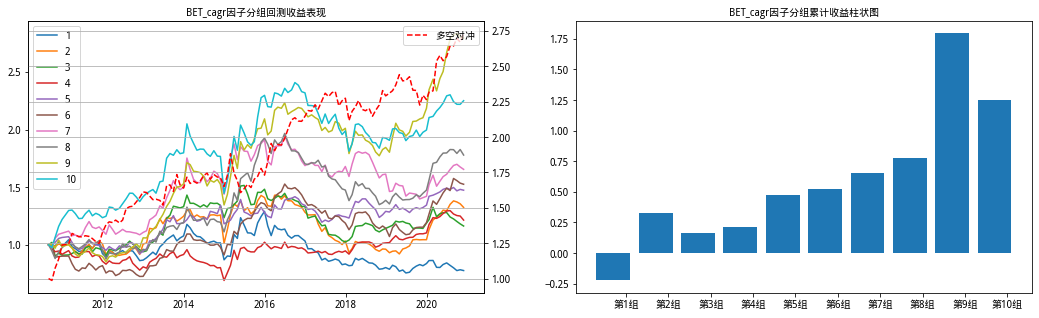

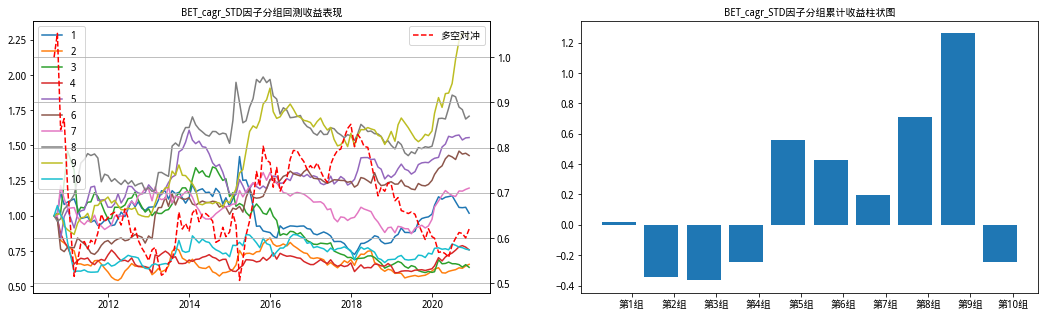

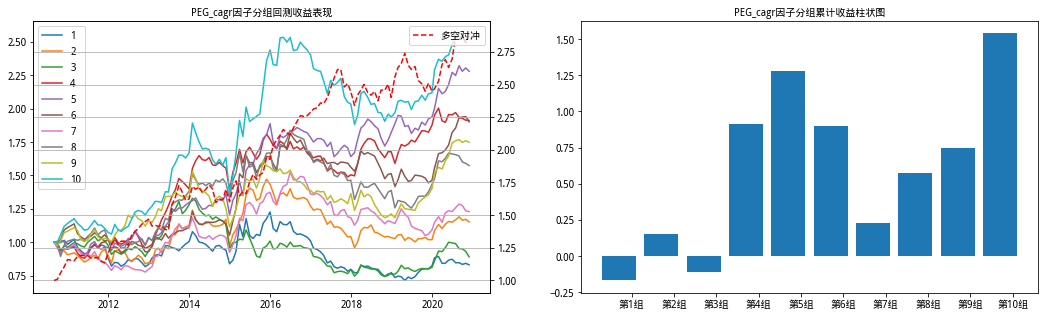

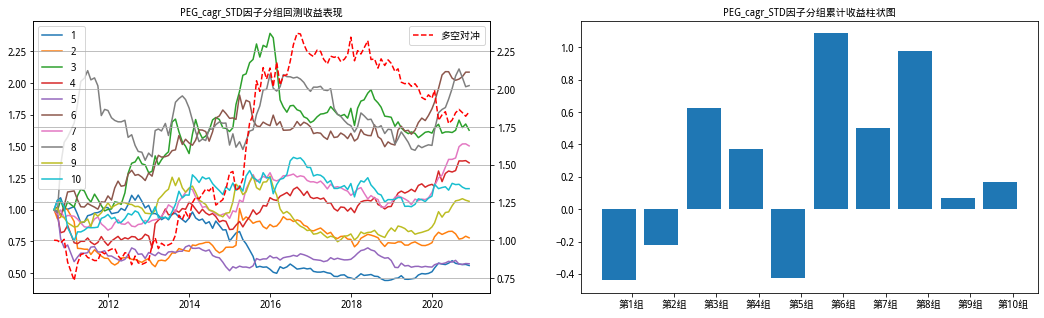

In [39]:
# 对纯净BET以及PEG因子进行IC测试和分组测试
ic_res, perf_df = factor_test_summary(a_factor_df, factor_list, 10)  
ic_res.columns =  ['tradeDate', 'BET_f', 'BET_f_STD', 'PEG_f', 'PEG_f_STD' ]      
ec_perf_df = test_discribe(ic_res, perf_df, factor_list, 'DY0001', 10)
plot_group_perf(ec_perf_df, 'BET_f', 10, u'BET_cagr因子')
plot_group_perf(ec_perf_df, 'BET_f_STD', 10, u'BET_cagr_STD因子')
plot_group_perf(ec_perf_df, 'PEG_f', 10, u'PEG_cagr因子')
plot_group_perf(ec_perf_df, 'PEG_f_STD', 10, u'PEG_cagr_STD因子')                                     

IC结果分析 <table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>IC</th>
      <th>IC标准差</th>
      <th>IC均值T统计量</th>
      <th>ICIR</th>
      <th>IC大于0的比例</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>BET_f</th>
      <td>2.19%</td>
      <td>6.43%</td>
      <td>3.85</td>
      <td>1.18</td>
      <td>65.62%</td>
    </tr>
    <tr>
      <th>BET_f_STD</th>
      <td>2.63%</td>
      <td>18.72%</td>
      <td>1.59</td>
      <td>0.49</td>
      <td>59.38%</td>
    </tr>
    <tr>
      <th>PEG_f</th>
      <td>2.10%</td>
      <td>6.38%</td>
      <td>3.73</td>
      <td>1.14</td>
      <td>62.50%</td>
    </tr>
    <tr>
      <th>PEG_f_STD</th>
      <td>0.80%</td>
      <td>14.68%</td>
      <td>0.62</td>
      <td>0.19</td>
      <td>57.81%</td>
    </tr>
  </tbody>
</table>
分组回测结果分析 <table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>多空组合年化收益</th>
      <th>多空年化波动</th>
      <th>多空夏普比</th>
      <th>多空最大回撤</th>
      <th>多空月度胜率</th>
      <th>第1组超额收益</th>
      <th>第2组超额收益</th>
      <th>第3组超额收益</th>
      <th>第4组超额收益</th>
      <th>第5组超额收益</th>
      <th>第6组超额收益</th>
      <th>第7组超额收益</th>
      <th>第8组超额收益</th>
      <th>第9组超额收益</th>
      <th>第10组超额收益</th>
    </tr>
    <tr>
      <th>factor_name</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>BET_f</th>
      <td>10.53%</td>
      <td>10.78%</td>
      <td>0.98</td>
      <td>14.65%</td>
      <td>59.84%</td>
      <td>8.36%</td>
      <td>13.53%</td>
      <td>11.67%</td>
      <td>12.13%</td>
      <td>13.67%</td>
      <td>15.09%</td>
      <td>15.95%</td>
      <td>15.95%</td>
      <td>20.44%</td>
      <td>18.89%</td>
    </tr>
    <tr>
      <th>BET_f_STD</th>
      <td>-2.29%</td>
      <td>19.58%</td>
      <td>-0.12</td>
      <td>51.93%</td>
      <td>50.00%</td>
      <td>9.77%</td>
      <td>6.09%</td>
      <td>4.64%</td>
      <td>7.15%</td>
      <td>13.05%</td>
      <td>12.53%</td>
      <td>12.32%</td>
      <td>14.92%</td>
      <td>17.26%</td>
      <td>7.48%</td>
    </tr>
    <tr>
      <th>PEG_f</th>
      <td>11.27%</td>
      <td>10.80%</td>
      <td>1.04</td>
      <td>10.63%</td>
      <td>63.93%</td>
      <td>8.63%</td>
      <td>12.26%</td>
      <td>9.31%</td>
      <td>16.56%</td>
      <td>18.44%</td>
      <td>17.05%</td>
      <td>12.54%</td>
      <td>15.05%</td>
      <td>15.73%</td>
      <td>19.89%</td>
    </tr>
    <tr>
      <th>PEG_f_STD</th>
      <td>7.78%</td>
      <td>17.08%</td>
      <td>0.46</td>
      <td>27.08%</td>
      <td>56.56%</td>
      <td>3.64%</td>
      <td>8.27%</td>
      <td>13.58%</td>
      <td>13.18%</td>
      <td>3.70%</td>
      <td>16.01%</td>
      <td>14.19%</td>
      <td>17.05%</td>
      <td>9.89%</td>
      <td>11.41%</td>
    </tr>
  </tbody>
</table>

In [40]:
def calc_factor_corr(factor_df, factor_list, style_factor_list):
    """
    计算因子秩相关系数, 并展示相关系数热力图
    参数：
        factor_df: DataFrame, 因子值
        factor_df: list, 因子列表
        title_part: str, 图片标题
    返回：
        DataFrame, 因子秩相关系数
    """
    factor_df[style_factor_list] = factor_df[style_factor_list].apply(lambda x: x.astype(float))
    date_corr_df = factor_df[['tradeDate']+style_factor_list].groupby('tradeDate').corr(method='spearman')
    date_corr_df = date_corr_df[style_factor_list]
    date_list = factor_df['tradeDate'].unique()
    corr_list = []
    for col in factor_list:
        corr_tmp = np.nanmean([date_corr_df.loc[date, col] for date in date_list], axis=0)
        corr_list.append(corr_tmp)

    corr_df = pd.DataFrame(corr_list, index=factor_list, columns=date_corr_df.columns)

    fig, ax = plt.subplots(figsize=(16, 4))
    sns.heatmap(corr_df, linewidths=0.08, ax=ax, vmax=1, vmin=-1, cmap='RdYlGn_r', annot=True)
    return corr_df

BET与PEG因子相关性测试分析...


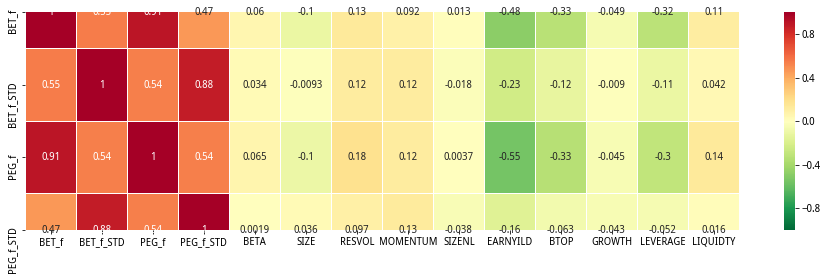

In [41]:
print ("BET与PEG因子相关性测试分析...")

factor_list = ['BET_f', 'BET_f_STD', 'PEG_f', 'PEG_f_STD']
# 去极值
w_factor_df = mad_winsorize(fac_df[['ticker', 'tradeDate']+factor_list], factor_list, sigma_n=3)
# 标准化
s_factor_df = w_factor_df.copy()
s_factor_df[factor_list] = s_factor_df.groupby('tradeDate')[factor_list].apply(lambda df: (df-df.mean()) / df.std())

mer_factor_df = s_factor_df.merge(style_fac_df, on=['ticker', 'tradeDate'])
style_factor_list = factor_list + style_list
corr_df = calc_factor_corr(mer_factor_df, factor_list, style_factor_list)


In [42]:
print ("本部分为不同投资域检验..." )

factor_list = ['BET_f_STD', 'PEG_f_STD']
fac_df_hs300 = s_fac_df.merge(df_hs300, on=['ticker', 'tradeDate'])
a_fac_df_hs300 = fac_process(fac_df_hs300, factor_list)
print ("沪深300中BET因子IC测试及分组多空绩效指标对比")
ic_res_hs300, perf_df_hs300 = factor_test_summary(a_fac_df_hs300, factor_list, 10)
ic_res_hs300.columns =  ['tradeDate', 'BET_f_STD', 'PEG_f_STD' ]
ec_perf_df300 = test_discribe(ic_res_hs300, perf_df_hs300, factor_list, '000300', 10)

fac_df_zz500 = s_fac_df.merge(df_zz500, on=['ticker', 'tradeDate'])
a_fac_df_zz500 = fac_process(fac_df_zz500, factor_list)
print ("中证500中BET因子IC测试及分组多空绩效指标对比")
ic_res_zz500, perf_df_zz500 = factor_test_summary(a_fac_df_zz500, factor_list, 10)
ic_res_zz500.columns =  ['tradeDate', 'BET_f_STD', 'PEG_f_STD' ]
ec_perf_df500 = test_discribe(ic_res_zz500, perf_df_zz500, factor_list, '000905', 10)

fac_df_zz800 = s_fac_df.merge(df_zz800, on=['ticker', 'tradeDate'])
a_fac_df_zz800 = fac_process(fac_df_zz800, factor_list)
print ("中证800中BET因子IC测试及分组多空绩效指标对比")
ic_res_zz800, perf_df_zz800 = factor_test_summary(a_fac_df_zz800, factor_list, 10)
ic_res_zz800.columns =  ['tradeDate', 'BET_f_STD', 'PEG_f_STD' ]
ec_perf_df800 = test_discribe(ic_res_zz800, perf_df_zz800, factor_list, '000906', 10)


本部分为不同投资域检验...
沪深300中BET因子IC测试及分组多空绩效指标对比
IC结果分析 <table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>IC</th>
      <th>IC标准差</th>
      <th>IC均值T统计量</th>
      <th>ICIR</th>
      <th>IC大于0的比例</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>BET_f_STD</th>
      <td>3.56%</td>
      <td>22.59%</td>
      <td>1.78</td>
      <td>0.55</td>
      <td>58.59%</td>
    </tr>
    <tr>
      <th>PEG_f_STD</th>
      <td>2.39%</td>
      <td>21.16%</td>
      <td>1.28</td>
      <td>0.39</td>
      <td>56.25%</td>
    </tr>
  </tbody>
</table>
分组回测结果分析 <table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>多空组合年化收益</th>
      <th>多空年化波动</th>
      <th>多空夏普比</th>
      <th>多空最大回撤</th>
      <th>多空月度胜率</th>
      <th>第1组超额收益</th>
      <th>第2组超额收益</th>
      <th>第3组超额收益</th>
      <th>第4组超额收益</th>
      <th>第5组超额收益</th>
      <th>第6组超额收益</th>
      <th>第7组超额收益</th>
      <th>第8组超额收

沪深300中BET因子IC测试及分组多空绩效指标对比
IC结果分析 <table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>IC</th>
      <th>IC标准差</th>
      <th>IC均值T统计量</th>
      <th>ICIR</th>
      <th>IC大于0的比例</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>BET_f_STD</th>
      <td>3.56%</td>
      <td>22.59%</td>
      <td>1.78</td>
      <td>0.55</td>
      <td>58.59%</td>
    </tr>
    <tr>
      <th>PEG_f_STD</th>
      <td>2.39%</td>
      <td>21.16%</td>
      <td>1.28</td>
      <td>0.39</td>
      <td>56.25%</td>
    </tr>
  </tbody>
</table>
分组回测结果分析 <table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>多空组合年化收益</th>
      <th>多空年化波动</th>
      <th>多空夏普比</th>
      <th>多空最大回撤</th>
      <th>多空月度胜率</th>
      <th>第1组超额收益</th>
      <th>第2组超额收益</th>
      <th>第3组超额收益</th>
      <th>第4组超额收益</th>
      <th>第5组超额收益</th>
      <th>第6组超额收益</th>
      <th>第7组超额收益</th>
      <th>第8组超额收益</th>
      <th>第9组超额收益</th>
      <th>第10组超额收益</th>
    </tr>
    <tr>
      <th>factor_name</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>BET_f_STD</th>
      <td>14.81%</td>
      <td>26.44%</td>
      <td>0.56</td>
      <td>38.34%</td>
      <td>56.20%</td>
      <td>7.37%</td>
      <td>7.70%</td>
      <td>5.57%</td>
      <td>13.71%</td>
      <td>11.73%</td>
      <td>13.24%</td>
      <td>8.79%</td>
      <td>12.39%</td>
      <td>16.06%</td>
      <td>22.18%</td>
    </tr>
    <tr>
      <th>PEG_f_STD</th>
      <td>6.89%</td>
      <td>21.55%</td>
      <td>0.32</td>
      <td>61.09%</td>
      <td>56.20%</td>
      <td>8.03%</td>
      <td>14.60%</td>
      <td>6.62%</td>
      <td>9.05%</td>
      <td>7.66%</td>
      <td>11.65%</td>
      <td>15.91%</td>
      <td>5.37%</td>
      <td>20.87%</td>
      <td>14.92%</td>
    </tr>
  </tbody>
</table>
中证500中BET因子IC测试及分组多空绩效指标对比
IC结果分析 <table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>IC</th>
      <th>IC标准差</th>
      <th>IC均值T统计量</th>
      <th>ICIR</th>
      <th>IC大于0的比例</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>BET_f_STD</th>
      <td>2.90%</td>
      <td>29.91%</td>
      <td>1.06</td>
      <td>0.34</td>
      <td>53.78%</td>
    </tr>
    <tr>
      <th>PEG_f_STD</th>
      <td>1.45%</td>
      <td>29.45%</td>
      <td>0.54</td>
      <td>0.17</td>
      <td>57.98%</td>
    </tr>
  </tbody>
</table>
分组回测结果分析 <table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>多空组合年化收益</th>
      <th>多空年化波动</th>
      <th>多空夏普比</th>
      <th>多空最大回撤</th>
      <th>多空月度胜率</th>
      <th>第1组超额收益</th>
      <th>第2组超额收益</th>
      <th>第3组超额收益</th>
      <th>第4组超额收益</th>
      <th>第5组超额收益</th>
      <th>第6组超额收益</th>
      <th>第7组超额收益</th>
      <th>第8组超额收益</th>
      <th>第9组超额收益</th>
      <th>第10组超额收益</th>
    </tr>
    <tr>
      <th>factor_name</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>BET_f_STD</th>
      <td>2.27%</td>
      <td>30.25%</td>
      <td>0.08</td>
      <td>68.35%</td>
      <td>54.08%</td>
      <td>11.80%</td>
      <td>5.94%</td>
      <td>13.57%</td>
      <td>19.40%</td>
      <td>12.78%</td>
      <td>10.42%</td>
      <td>26.40%</td>
      <td>5.47%</td>
      <td>22.43%</td>
      <td>14.07%</td>
    </tr>
    <tr>
      <th>PEG_f_STD</th>
      <td>2.65%</td>
      <td>32.17%</td>
      <td>0.08</td>
      <td>81.28%</td>
      <td>51.02%</td>
      <td>10.13%</td>
      <td>1.83%</td>
      <td>14.90%</td>
      <td>28.91%</td>
      <td>5.50%</td>
      <td>25.15%</td>
      <td>18.25%</td>
      <td>11.36%</td>
      <td>6.17%</td>
      <td>12.78%</td>
    </tr>
  </tbody>
</table>
中证800中BET因子IC测试及分组多空绩效指标对比
IC结果分析 <table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>IC</th>
      <th>IC标准差</th>
      <th>IC均值T统计量</th>
      <th>ICIR</th>
      <th>IC大于0的比例</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>BET_f_STD</th>
      <td>2.56%</td>
      <td>18.96%</td>
      <td>1.53</td>
      <td>0.47</td>
      <td>59.38%</td>
    </tr>
    <tr>
      <th>PEG_f_STD</th>
      <td>1.50%</td>
      <td>15.24%</td>
      <td>1.12</td>
      <td>0.34</td>
      <td>59.38%</td>
    </tr>
  </tbody>
</table>
分组回测结果分析 <table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>多空组合年化收益</th>
      <th>多空年化波动</th>
      <th>多空夏普比</th>
      <th>多空最大回撤</th>
      <th>多空月度胜率</th>
      <th>第1组超额收益</th>
      <th>第2组超额收益</th>
      <th>第3组超额收益</th>
      <th>第4组超额收益</th>
      <th>第5组超额收益</th>
      <th>第6组超额收益</th>
      <th>第7组超额收益</th>
      <th>第8组超额收益</th>
      <th>第9组超额收益</th>
      <th>第10组超额收益</th>
    </tr>
    <tr>
      <th>factor_name</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>BET_f_STD</th>
      <td>-5.62%</td>
      <td>17.92%</td>
      <td>-0.31</td>
      <td>64.03%</td>
      <td>46.72%</td>
      <td>10.53%</td>
      <td>3.02%</td>
      <td>8.17%</td>
      <td>13.04%</td>
      <td>4.76%</td>
      <td>5.07%</td>
      <td>18.39%</td>
      <td>21.64%</td>
      <td>14.43%</td>
      <td>4.91%</td>
    </tr>
    <tr>
      <th>PEG_f_STD</th>
      <td>-1.52%</td>
      <td>17.67%</td>
      <td>-0.09</td>
      <td>47.17%</td>
      <td>50.00%</td>
      <td>8.15%</td>
      <td>7.39%</td>
      <td>5.50%</td>
      <td>5.94%</td>
      <td>6.31%</td>
      <td>15.98%</td>
      <td>17.51%</td>
      <td>17.84%</td>
      <td>13.89%</td>
      <td>6.63%</td>
    </tr>
  </tbody>
</table>

In [78]:
def ic_indus_table(df, fac_list):
    # 函数：获取某行业的因子时间序列数据ICIR值
    ic_df = calc_ic(df, mret_df, fac_list, return_col_name='nxt_ret', ic_type='spearman')
    fac_list_add = ['tradeDate']
    fac_list2 = fac_list_add + fac_list
    ic_df.columns = fac_list2
    ic_table = ic_describe(ic_df, fac_list, annual_len=12)
    return ic_table

fac_ind_df = fac_df.merge(indus_df, on=['ticker', 'tradeDate'])
# 由于一级行业综合金融产生时间晚、数据量少，将其删除
fac_ind_df = fac_ind_df[fac_ind_df.industryName1 != '综合金融']
# 因子方向调整
fac_list = ['BET_f_STD', 'PEG_f_STD']
fac_ind_df[fac_list] = - fac_ind_df[fac_list]


In [79]:
# 统计各行业中均衡估值因子的IC测试表现
ic_indus_table = fac_ind_df.groupby(['industryName1']).apply(lambda df2: ic_indus_table(df2, fac_list)[['IC', 'ICIR']].unstack())
#ic_indus_table  = ic_indus_table.sort_values(by=[('IC','BET_f_STD')], ascending=False, inplace=True)
print (u'均衡估值因子在不同中信一级行业的IC测试表现', ic_indus_table)

均衡估值因子在不同中信一级行业的IC测试表现                      IC                ICIR          
              BET_f_STD PEG_f_STD BET_f_STD PEG_f_STD
industryName1                                        
交通运输              9.92%     5.44%      0.56      0.30
传媒                7.25%     4.82%      0.43      0.29
农林牧渔              2.63%   -10.30%      0.12     -0.48
医药               -0.84%    -1.21%     -0.06     -0.09
商贸零售            -10.80%    -9.01%     -0.57     -0.50
国防军工             -0.20%     2.26%     -0.01      0.13
基础化工             -2.65%    -2.38%     -0.15     -0.13
家电               -9.15%   -11.38%     -0.49     -0.60
建材                6.49%    17.30%      0.29      0.83
建筑                6.83%     5.09%      0.40      0.30
房地产              16.10%    11.37%      0.98      0.67
有色金属              3.02%    11.22%      0.13      0.52
机械               -0.69%    -0.38%     -0.04     -0.02
汽车               -0.91%    -0.39%     -0.05     -0.02
消费者服务             1.08%     2.53%      0.06      0.13
煤炭   

,ticker,tradeDate,cagr_growth,fy1_growth,FY2_gap,FY1_gap,PE,NPParentCompanyGrowRate,NegMktValue,PEG_h,BET_h,BET_f,BET_c,PEG_f,PEG_c,PEG_f_STD,BET_f_STD,industryName1
0,000001,20090123,NaN,5.217683,1.0,1.0,8.8309,0.7695,3.241281e+10,11.476153,3.598286,2.107796,NaN,1.692494,NaN,NaN,NaN,银行
1,000001,20090527,0.191133,0.083934,2.0,1.0,75.6916,-0.7653,4.967737e+10,NaN,NaN,24.754320,15.658325,901.801148,396.015183,NaN,NaN,银行
2,000001,20090630,NaN,0.131591,1.0,1.0,92.5779,-0.7653,6.379637e+10,NaN,NaN,20.860644,NaN,703.529906,NaN,NaN,NaN,银行
3,000001,20090831,NaN,NaN,NaN,NaN,72.2731,-0.7870,5.318314e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,银行
4,000001,20090930,0.241963,0.229626,2.0,1.0,79.5044,-0.7870,5.850437e+10,NaN,NaN,14.309099,13.879148,346.233833,328.580458,NaN,NaN,银行
5,000001,20091231,NaN,0.283153,NaN,1.0,80.9873,-0.7717,7.126066e+10,NaN,NaN,12.735446,NaN,286.019203,NaN,NaN,NaN,银行
6,000001,20100430,NaN,0.242812,1.0,1.0,11.6367,6.4963,6.011979e+10,1.791281,2.153752,6.172224,NaN,47.924705,NaN,NaN,NaN,银行
7,000001,20100630,NaN,0.169849,1.0,1.0,11.1218,6.4963,5.437499e+10,1.712021,2.131585,6.762842,NaN,65.480340,NaN,NaN,NaN,银行
8,000001,20100730,NaN,0.262998,NaN,1.0,11.1218,6.4963,5.437499e+10,1.712021,2.131585,5.856263,NaN,42.288484,NaN,NaN,NaN,银行
9,000001,20100831,NaN,0.218290,1.0,1.0,10.6081,6.3600,5.437499e+10,1.667940,2.117351,6.070710,NaN,48.596324,NaN,NaN,NaN,银行


None
